<a href="https://colab.research.google.com/github/maia-cybar/PySpark-Project/blob/main/Copy_of_PysparkProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,DateType
from pyspark.sql.functions import month,year,quarter
from pyspark.sql.functions import count,countDistinct
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd




In [ ]:
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [ ]:
mySchema = StructType([
    StructField('product_id', IntegerType(), True),
    StructField('customer_id', StringType(), True),
    StructField('order_date', DateType(), True),
    StructField('location', StringType(), True),
    StructField('source_order', StringType(), True)
])

sales_df=spark.read.format("csv").option("inferschema","true").schema(mySchema).load("/content/drive/MyDrive/Colab Notebooks/pysparpro/sales.csv")

In [ ]:
#Deriving year month, quarter
sales_df=sales_df.withColumn("order_month",month(sales_df.order_date))
sales_df=sales_df.withColumn("order_year",year(sales_df.order_date))
sales_df=sales_df.withColumn("order_quarter",quarter(sales_df.order_date))
sales_df.show()

+----------+-----------+----------+--------+------------+-----------+----------+-------------+
|product_id|customer_id|order_date|location|source_order|order_month|order_year|order_quarter|
+----------+-----------+----------+--------+------------+-----------+----------+-------------+
|         1|          A|2023-01-01|   India|      Swiggy|          1|      2023|            1|
|         2|          A|2022-01-01|   India|      Swiggy|          1|      2022|            1|
|         2|          A|2023-01-07|   India|      Swiggy|          1|      2023|            1|
|         3|          A|2023-01-10|   India|  Restaurant|          1|      2023|            1|
|         3|          A|2022-01-11|   India|      Swiggy|          1|      2022|            1|
|         3|          A|2023-01-11|   India|  Restaurant|          1|      2023|            1|
|         2|          B|2022-02-01|   India|      Swiggy|          2|      2022|            1|
|         2|          B|2023-01-02|   India|      

In [ ]:
menuSchema = StructType([
    StructField('product_id', IntegerType(), True),
    StructField('product_name', StringType(), True),
    StructField('price', StringType(), True)

])


menu_df=spark.read.format("csv").option("inferschema","true").schema(menuSchema).load("/content/drive/MyDrive/Colab Notebooks/pysparpro/menu.csv")
menu_df.show()


+----------+------------+-----+
|product_id|product_name|price|
+----------+------------+-----+
|         1|       PIZZA|  100|
|         2|     Chowmin|  150|
|         3|    sandwich|  120|
|         4|        Dosa|  110|
|         5|     Biryani|   80|
|         6|       Pasta|  180|
+----------+------------+-----+



In [ ]:
#Total Amount spent by each customer

total_amount_spent= sales_df.join(menu_df,'product_id').groupBy('customer_id').agg({'price':'sum'}).orderBy('customer_id')
total_amount_spent.show()




+-----------+----------+
|customer_id|sum(price)|
+-----------+----------+
|          A|    4260.0|
|          B|    4440.0|
|          C|    2400.0|
|          D|    1200.0|
|          E|    2040.0|
+-----------+----------+



,customer_id,Price
0,A,4260.0
1,B,4440.0
2,C,2400.0
3,D,1200.0
4,E,2040.0


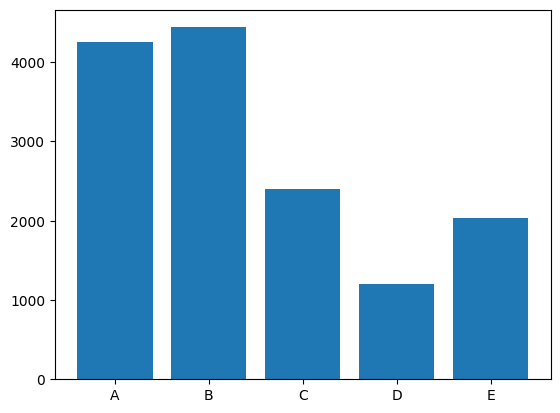

In [ ]:
pandas_df=total_amount_spent.toPandas()
pandas_df.rename(columns= {'sum(price)' : 'Price'}, inplace=True)
pandas_df.dtypes
display(pandas_df )
customer_id=pandas_df['customer_id']

Price=pandas_df['Price']
plt.bar(customer_id,Price)
plt.show()

In [ ]:
#yearly sales
df2= sales_df.join(menu_df,'product_id').groupBy('order_year').agg({'price':'sum'}).orderBy('order_year')
df2.show()

+----------+----------+
|order_year|sum(price)|
+----------+----------+
|      2022|    4350.0|
|      2023|    9990.0|
+----------+----------+



In [ ]:
df3=df2.toPandas()
df3.rename(columns= {'sum(price)' : 'Price'}, inplace=True)

display(df3 )
x=df3["order_year"]
y=df3["Price"]


plt.pie(y, x)
plt.show()

,order_year,Price
0,2022,4350.0
1,2023,9990.0


ValueError: Image size of 346711x487787 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

In [ ]:
#Quarterly Sale
df_quarterly= sales_df.join(menu_df,'product_id').groupBy('order_quarter').agg({'price':'sum'}).orderBy('order_quarter')
df_quarterly.show()

+-------------+----------+
|order_quarter|sum(price)|
+-------------+----------+
|            1|    6600.0|
|            2|    5920.0|
|            3|     910.0|
|            4|     910.0|
+-------------+----------+



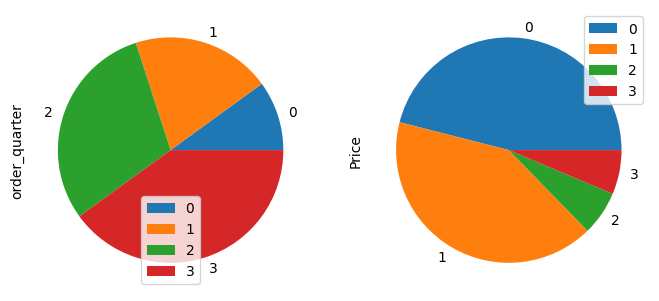

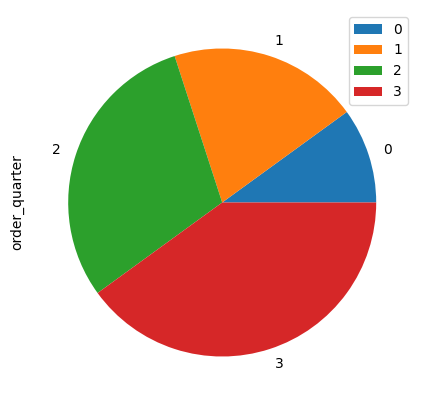

In [ ]:
df_quarterly_pandas=df_quarterly.toPandas()
df_quarterly_pandas.rename(columns= {'sum(price)' : 'Price'}, inplace=True)

df_quarterly_pandas.plot(kind='pie', subplots=True, figsize=(8, 8))

plt.show()

plot = df_quarterly_pandas.plot.pie(y='order_quarter', figsize=(5, 5))



In [ ]:
 #The number of orders by category
most_df=(sales_df.join(menu_df,'product_id').groupby('product_id','product_name').agg(count('product_id')).alias('product_count')).orderBy('product_count',ascending=0).limt(5)
most_df.show()


AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `product_count` cannot be resolved. Did you mean one of the following? [`product_id`, `product_name`, `count(product_id)`].;
'Sort ['product_count DESC NULLS LAST], true
+- SubqueryAlias product_count
   +- Aggregate [product_id#0, product_name#74], [product_id#0, product_name#74, count(product_id#0) AS count(product_id)#270L]
      +- Project [product_id#0, customer_id#1, order_date#2, location#3, source_order#4, order_month#10, order_year#18, order_quarter#26, product_name#74, price#75]
         +- Join Inner, (product_id#0 = product_id#73)
            :- Project [product_id#0, customer_id#1, order_date#2, location#3, source_order#4, order_month#10, order_year#18, quarter(order_date#2) AS order_quarter#26]
            :  +- Project [product_id#0, customer_id#1, order_date#2, location#3, source_order#4, order_month#10, year(order_date#2) AS order_year#18]
            :     +- Project [product_id#0, customer_id#1, order_date#2, location#3, source_order#4, month(order_date#2) AS order_month#10]
            :        +- Relation [product_id#0,customer_id#1,order_date#2,location#3,source_order#4] csv
            +- Relation [product_id#73,product_name#74,price#75] csv


In [ ]:
#frequency of customer visted
df_dist=sales_df.filter(sales_df.source_order=='Restaurant').groupBy('customer_id').agg(countDistinct('order_date'))
df_dist.show()


+-----------+--------------------------+
|customer_id|count(DISTINCT order_date)|
+-----------+--------------------------+
|          E|                         5|
|          B|                         6|
|          D|                         1|
|          C|                         3|
|          A|                         6|
+-----------+--------------------------+



In [ ]:
#Total sales by each country
total_amount_country= sales_df.join(menu_df,'product_id').groupBy('location').agg({'price':'sum'})
total_amount_country.show()

+--------+----------+
|location|sum(price)|
+--------+----------+
|   India|    4860.0|
|     USA|    2460.0|
|      UK|    7020.0|
+--------+----------+



In [ ]:
pandas_country=total_amount_country.toPandas()
display(pandas_country)


#Location=pandas_country['location']
#sum_1=pandas_country['sum(price)']
#plt.pie(pandas_country['location'],pandas_country['sum(price)'])
#plt.show()

,location,sum(price)
0,India,4860.0
1,USA,2460.0
2,UK,7020.0


,location,Price
0,India,4860.0
1,USA,2460.0
2,UK,7020.0


<BarContainer object of 3 artists>

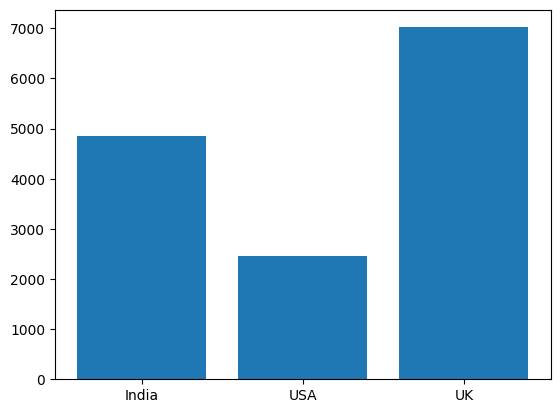

In [ ]:
pandas_country.rename(columns= {'sum(price)' : 'Price'}, inplace=True)
display(pandas_country)
pandas_country.dtypes
plt.bar(pandas_country['location'],pandas_country['Price'])


In [ ]:
#Total sles by order_source
total_amount_order_source= sales_df.join(menu_df,'product_id').groupBy('source_order').agg({'price':'sum'})
total_amount_order_source.show()


+------------+----------+
|source_order|sum(price)|
+------------+----------+
|      zomato|    4920.0|
|      Swiggy|    6330.0|
|  Restaurant|    3090.0|
+------------+----------+

